Taken from Gupta and Mendes, *An Overview of Network-Based and -Free Approaches for Stochastic Simulation of Biochemical Systems*, Computation, 6 (9), 2018.

In [9]:
using DifferentialEquations, DiffEqProblemLibrary, Plots
gr()

Plots.GRBackend()

# Plot solutions by each method

In [10]:
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
jprob   = prob_jump_multistate
prob    = jprob.discrete_prob
tf      = jprob.tstop
rn      = jprob.network
varlegs = ["A_P", "A_bound_P", "A_unbound_P", "RLA_P"]
varsyms = [
    [:S7,:S8,:S9], 
    [:S9],
    [:S7,:S8],
    [:S7]
]
varidxs = []
fmt = :png
for vars in varsyms
    push!(varidxs, [findfirst(rn.syms, sym) for sym in vars])
end

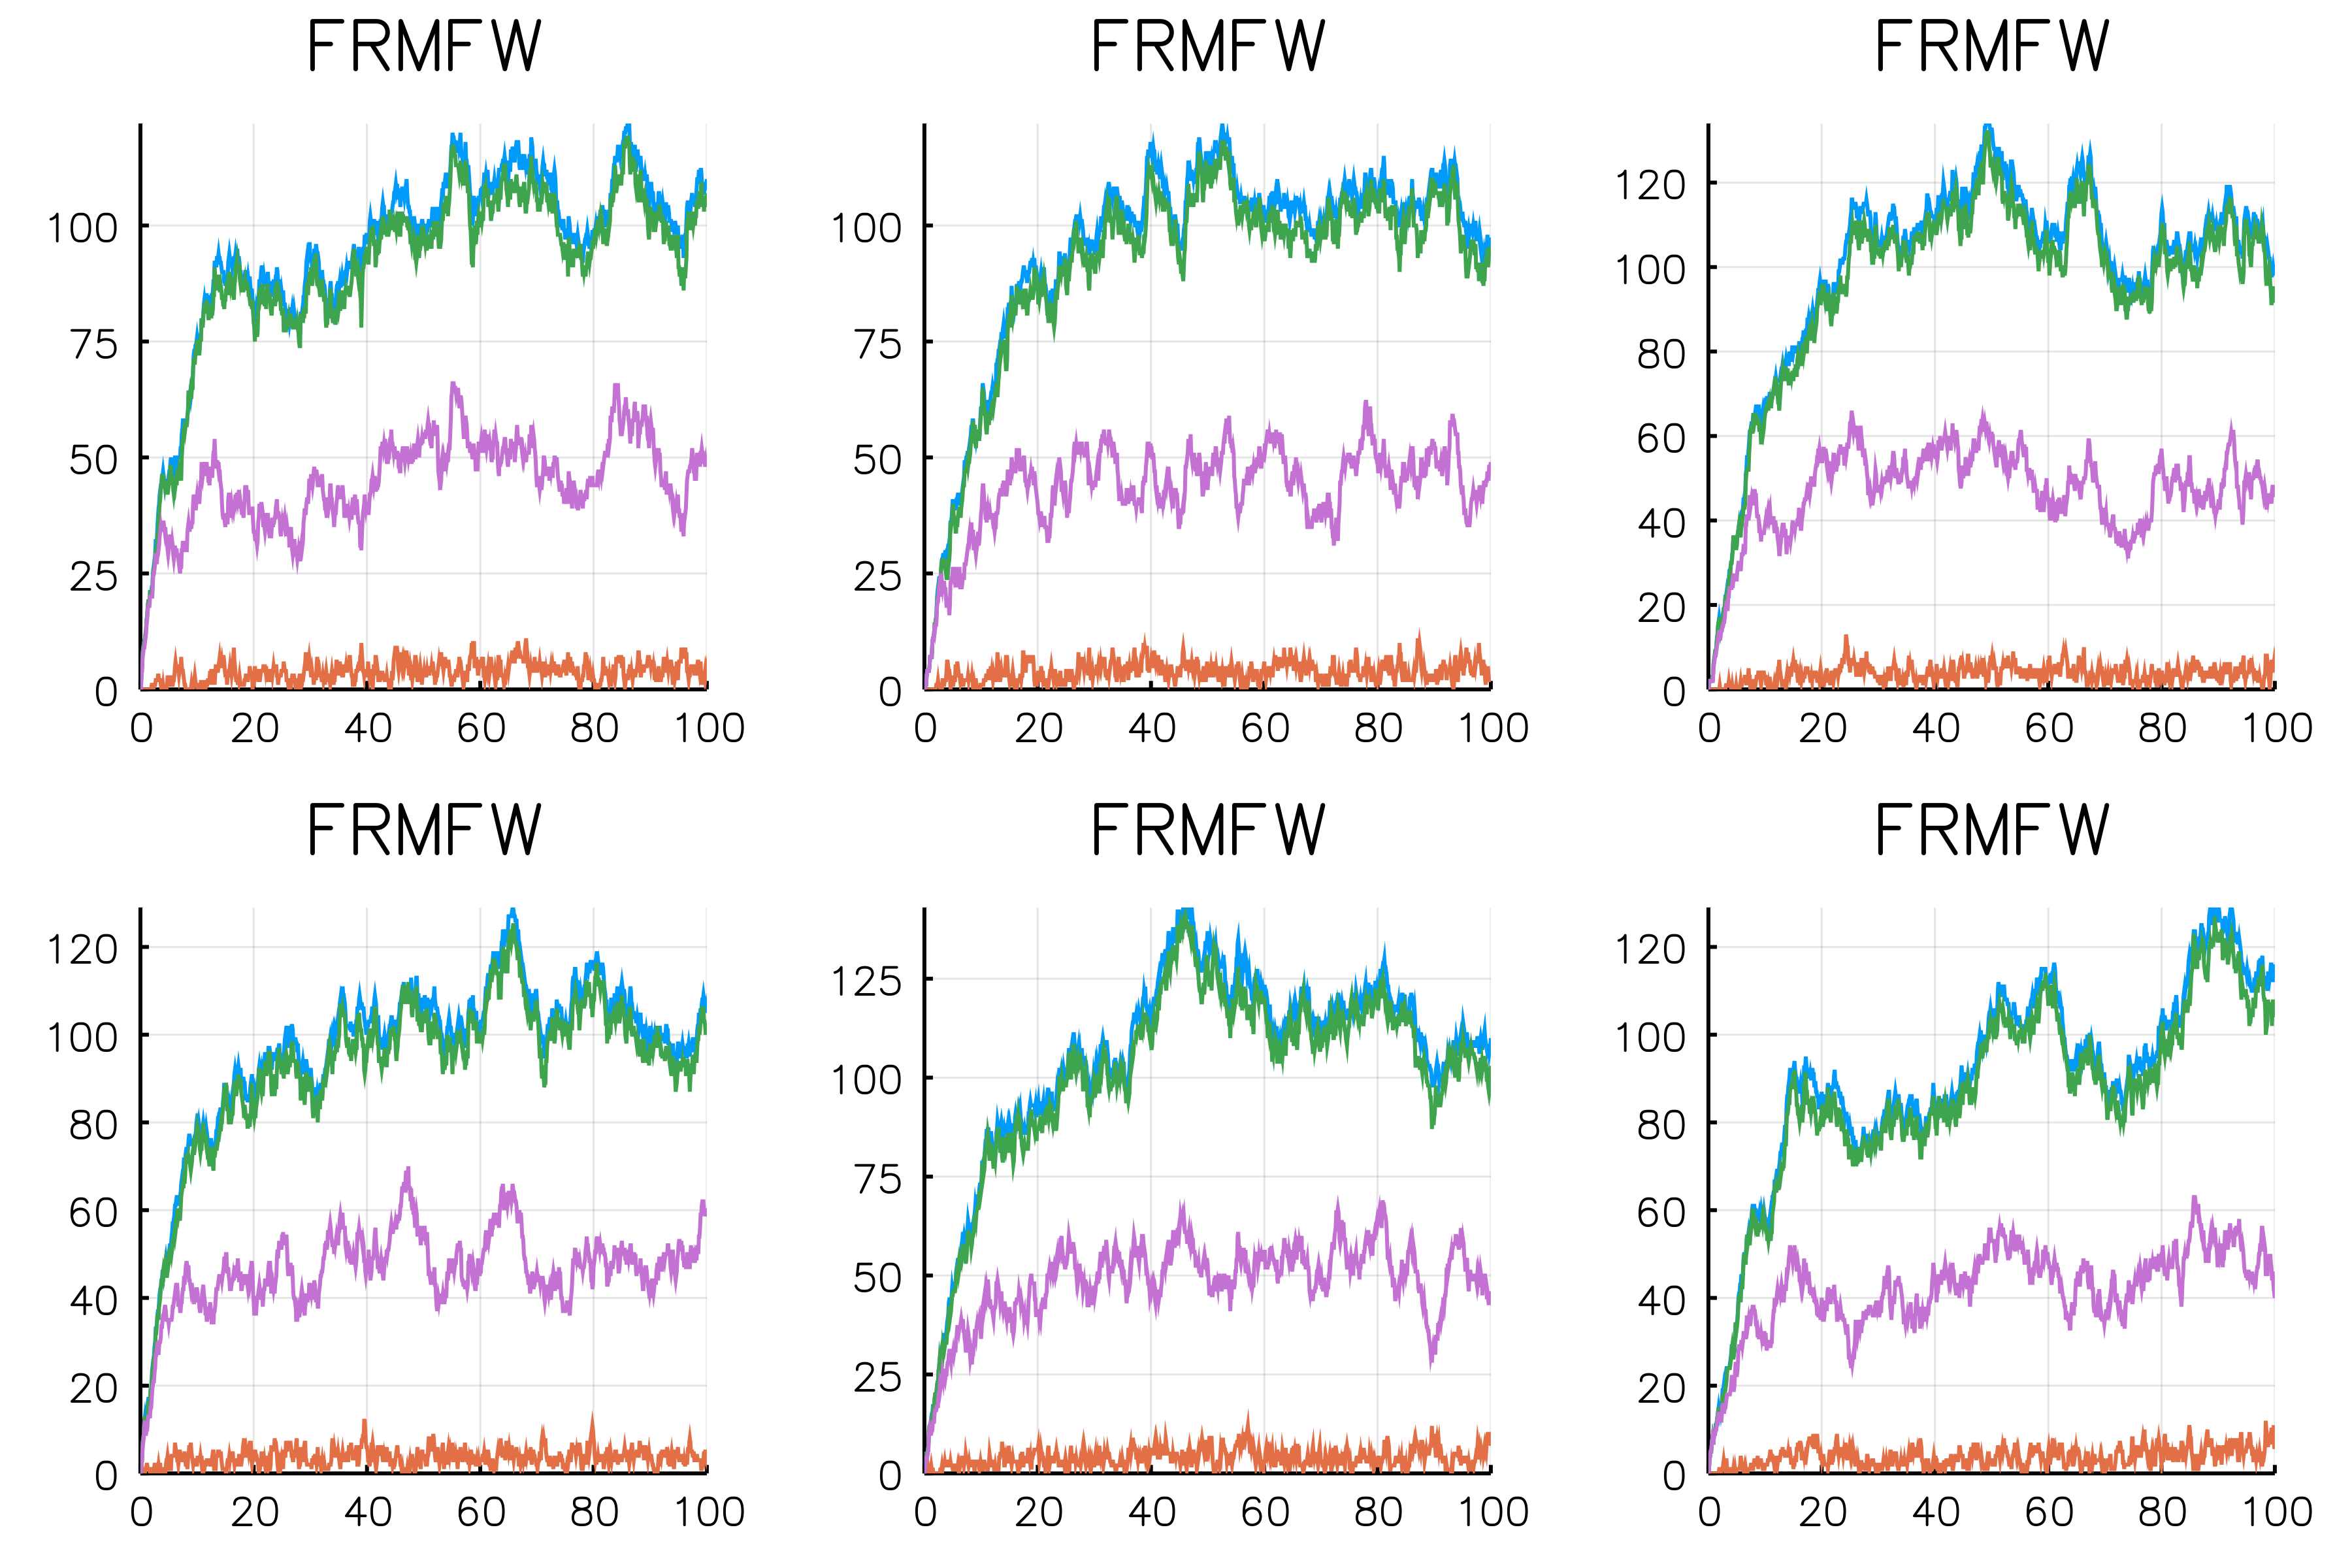

In [3]:
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    solv = zeros(1001,4)
    for (i,varidx) in enumerate(varidxs)
        solv[:,i] = sum(sol[varidx,:],1)
    end
    if i < length(methods)
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=false,format=fmt))
    else
        push!(p, plot(sol.t,solv,title=shortlabels[i],legend=true,labels=varlegs,format=fmt))
    end
end
plot(p...,format=fmt)

# Benchmarking performance of the methods

In [11]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [12]:
nsims = 500
benchmarks = Vector{Vector{Float64}}()
gc()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [13]:
medtimes = Vector{Float64}(length(methods))
stdtimes = Vector{Float64}(length(methods))
avgtimes = Vector{Float64}(length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end
using DataFrames

df = DataFrame(names=shortlabels,medtimes=medtimes,relmedtimes=(medtimes/medtimes[1]),avgtimes=avgtimes, std=stdtimes, cv=stdtimes./avgtimes)

,names,medtimes,relmedtimes,avgtimes,std,cv
1,Direct,0.0194615,1.0,0.0198973,0.00162438,0.0816384
2,DirectFW,0.0184064,0.945788,0.0192029,0.00187697,0.0977443
3,FRM,0.0278696,1.43204,0.0284592,0.002145,0.075371
4,FRMFW,0.0304107,1.56261,0.0312631,0.00266068,0.0851063
5,SortingDirect,0.0139176,0.715136,0.0146057,0.00149849,0.102597
6,NRM,0.0309054,1.58803,0.0326453,0.00380525,0.116563


Ignore the following, they use `BenchmarkTools` and may have some issues.

In [8]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())
    push!(benchmarks, @benchmark (for i = 1:10; solve($jump_prob, $SSAStepper()); end))
end

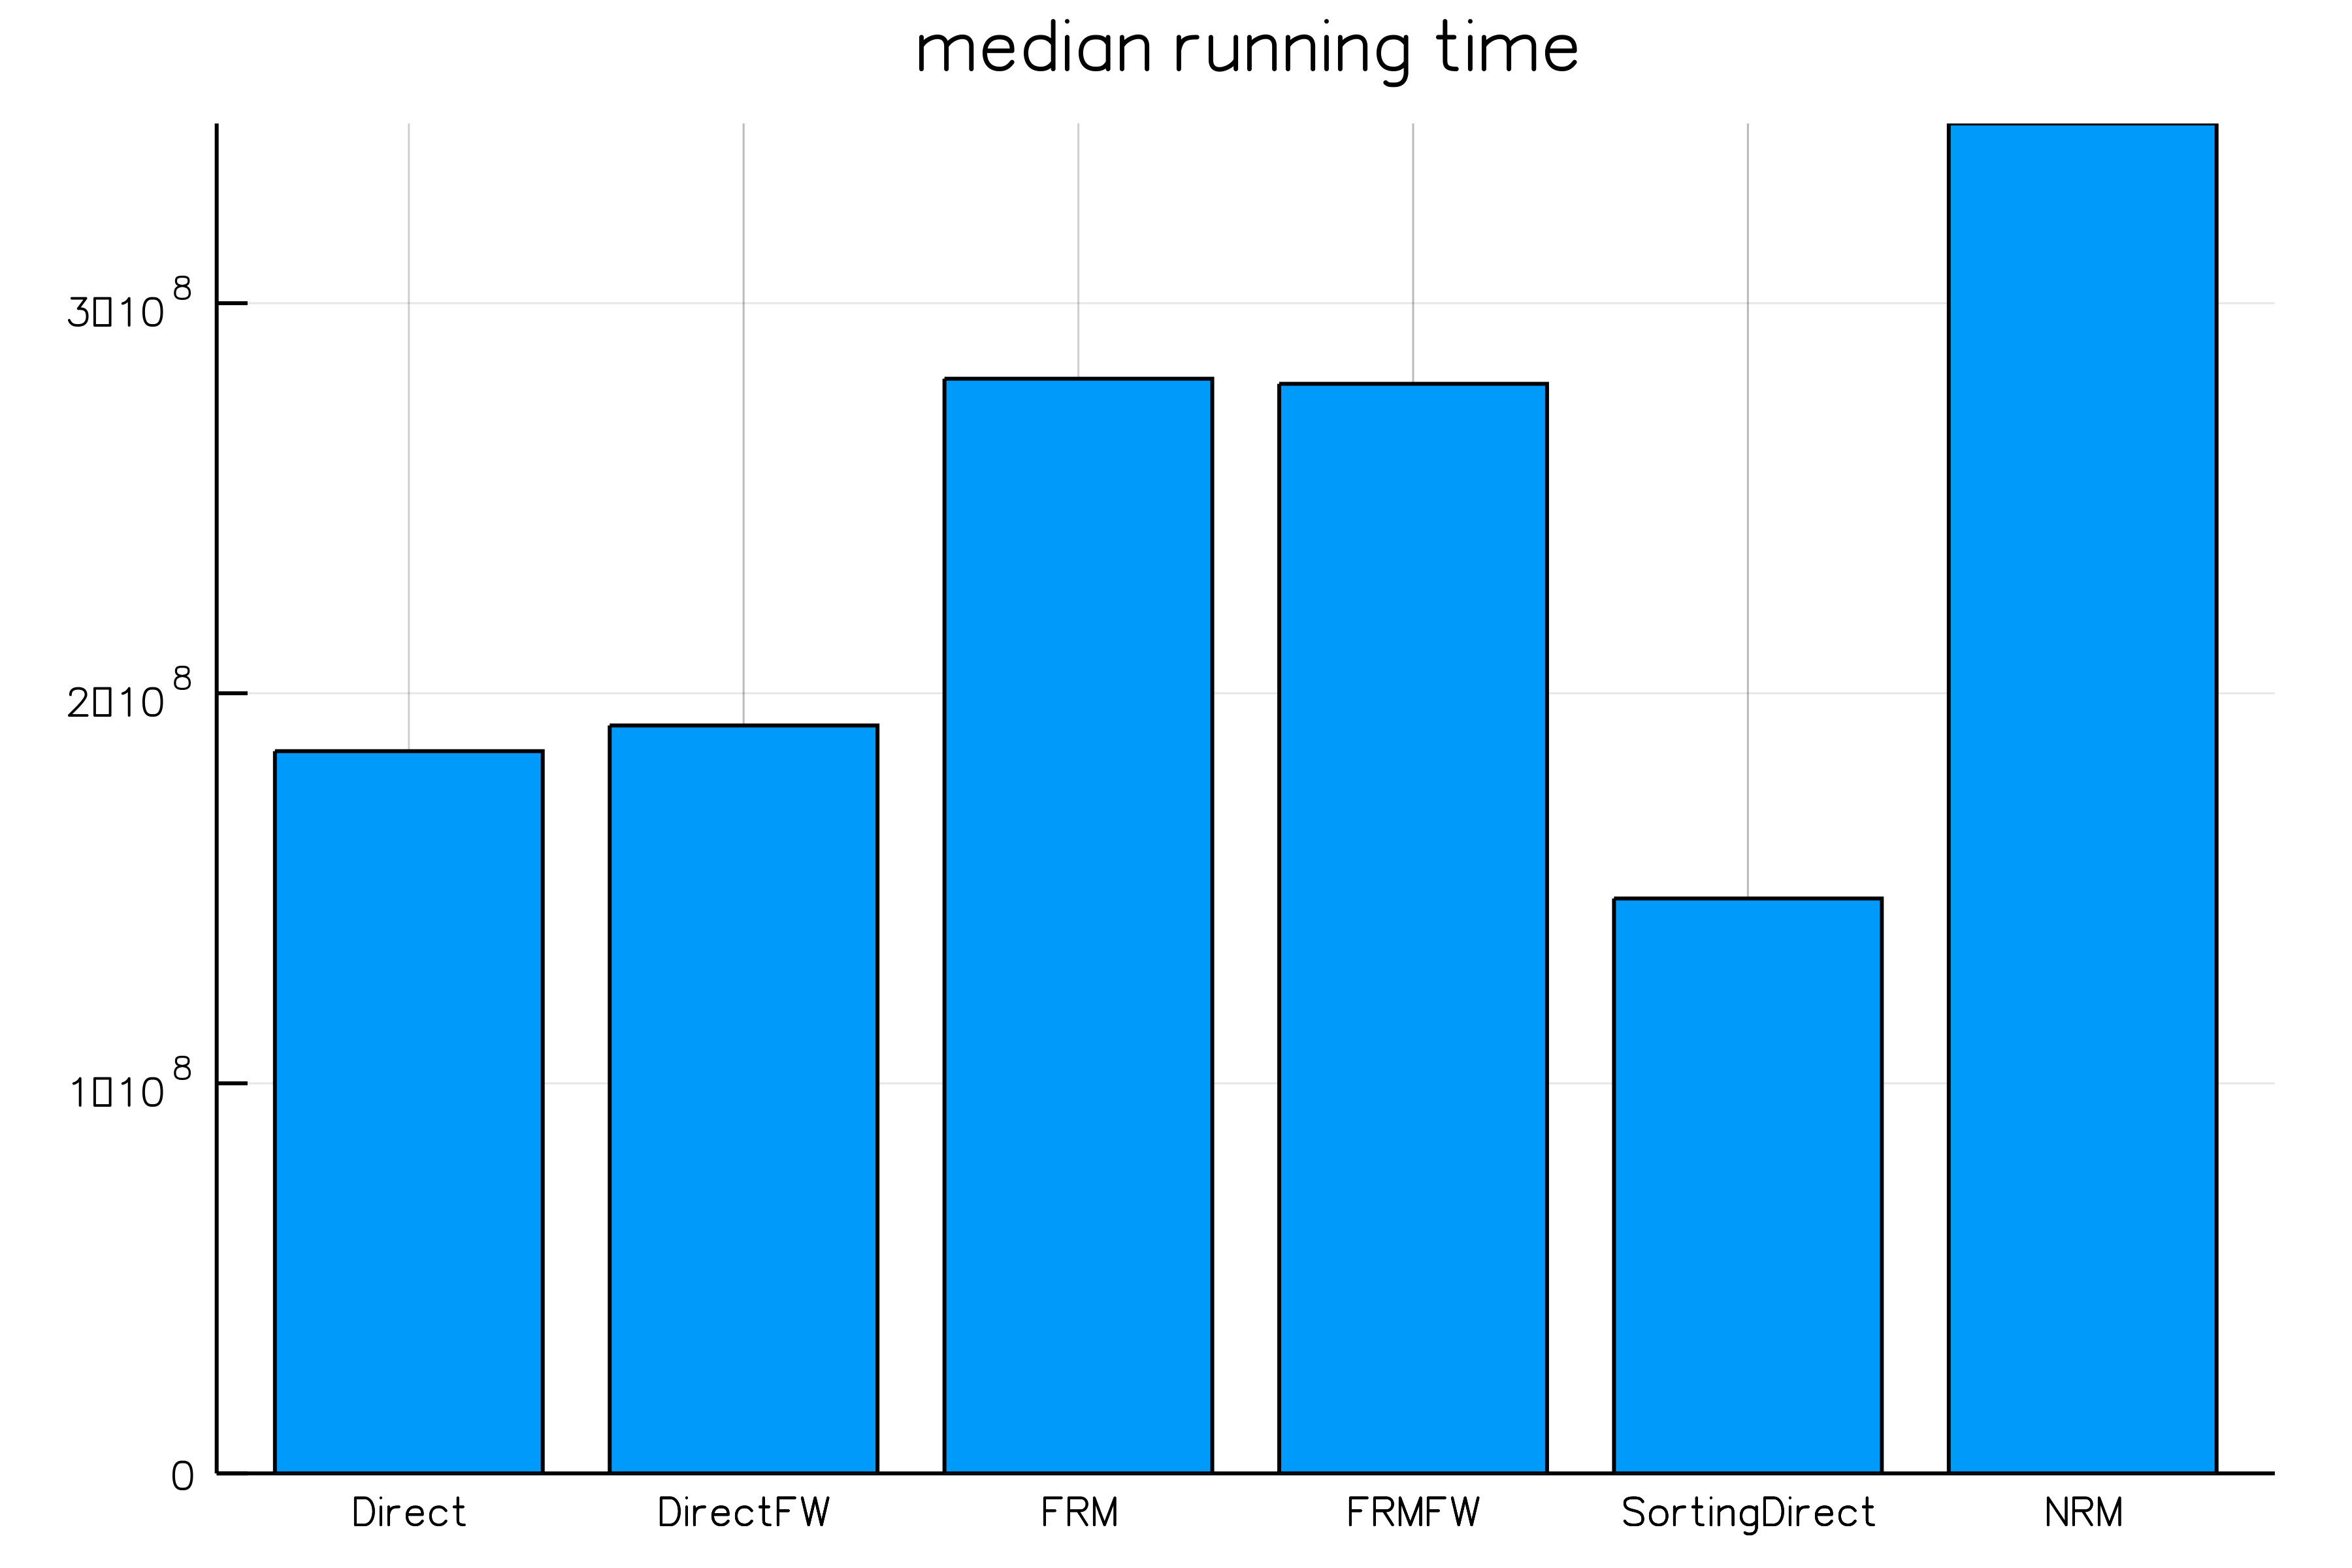

In [9]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

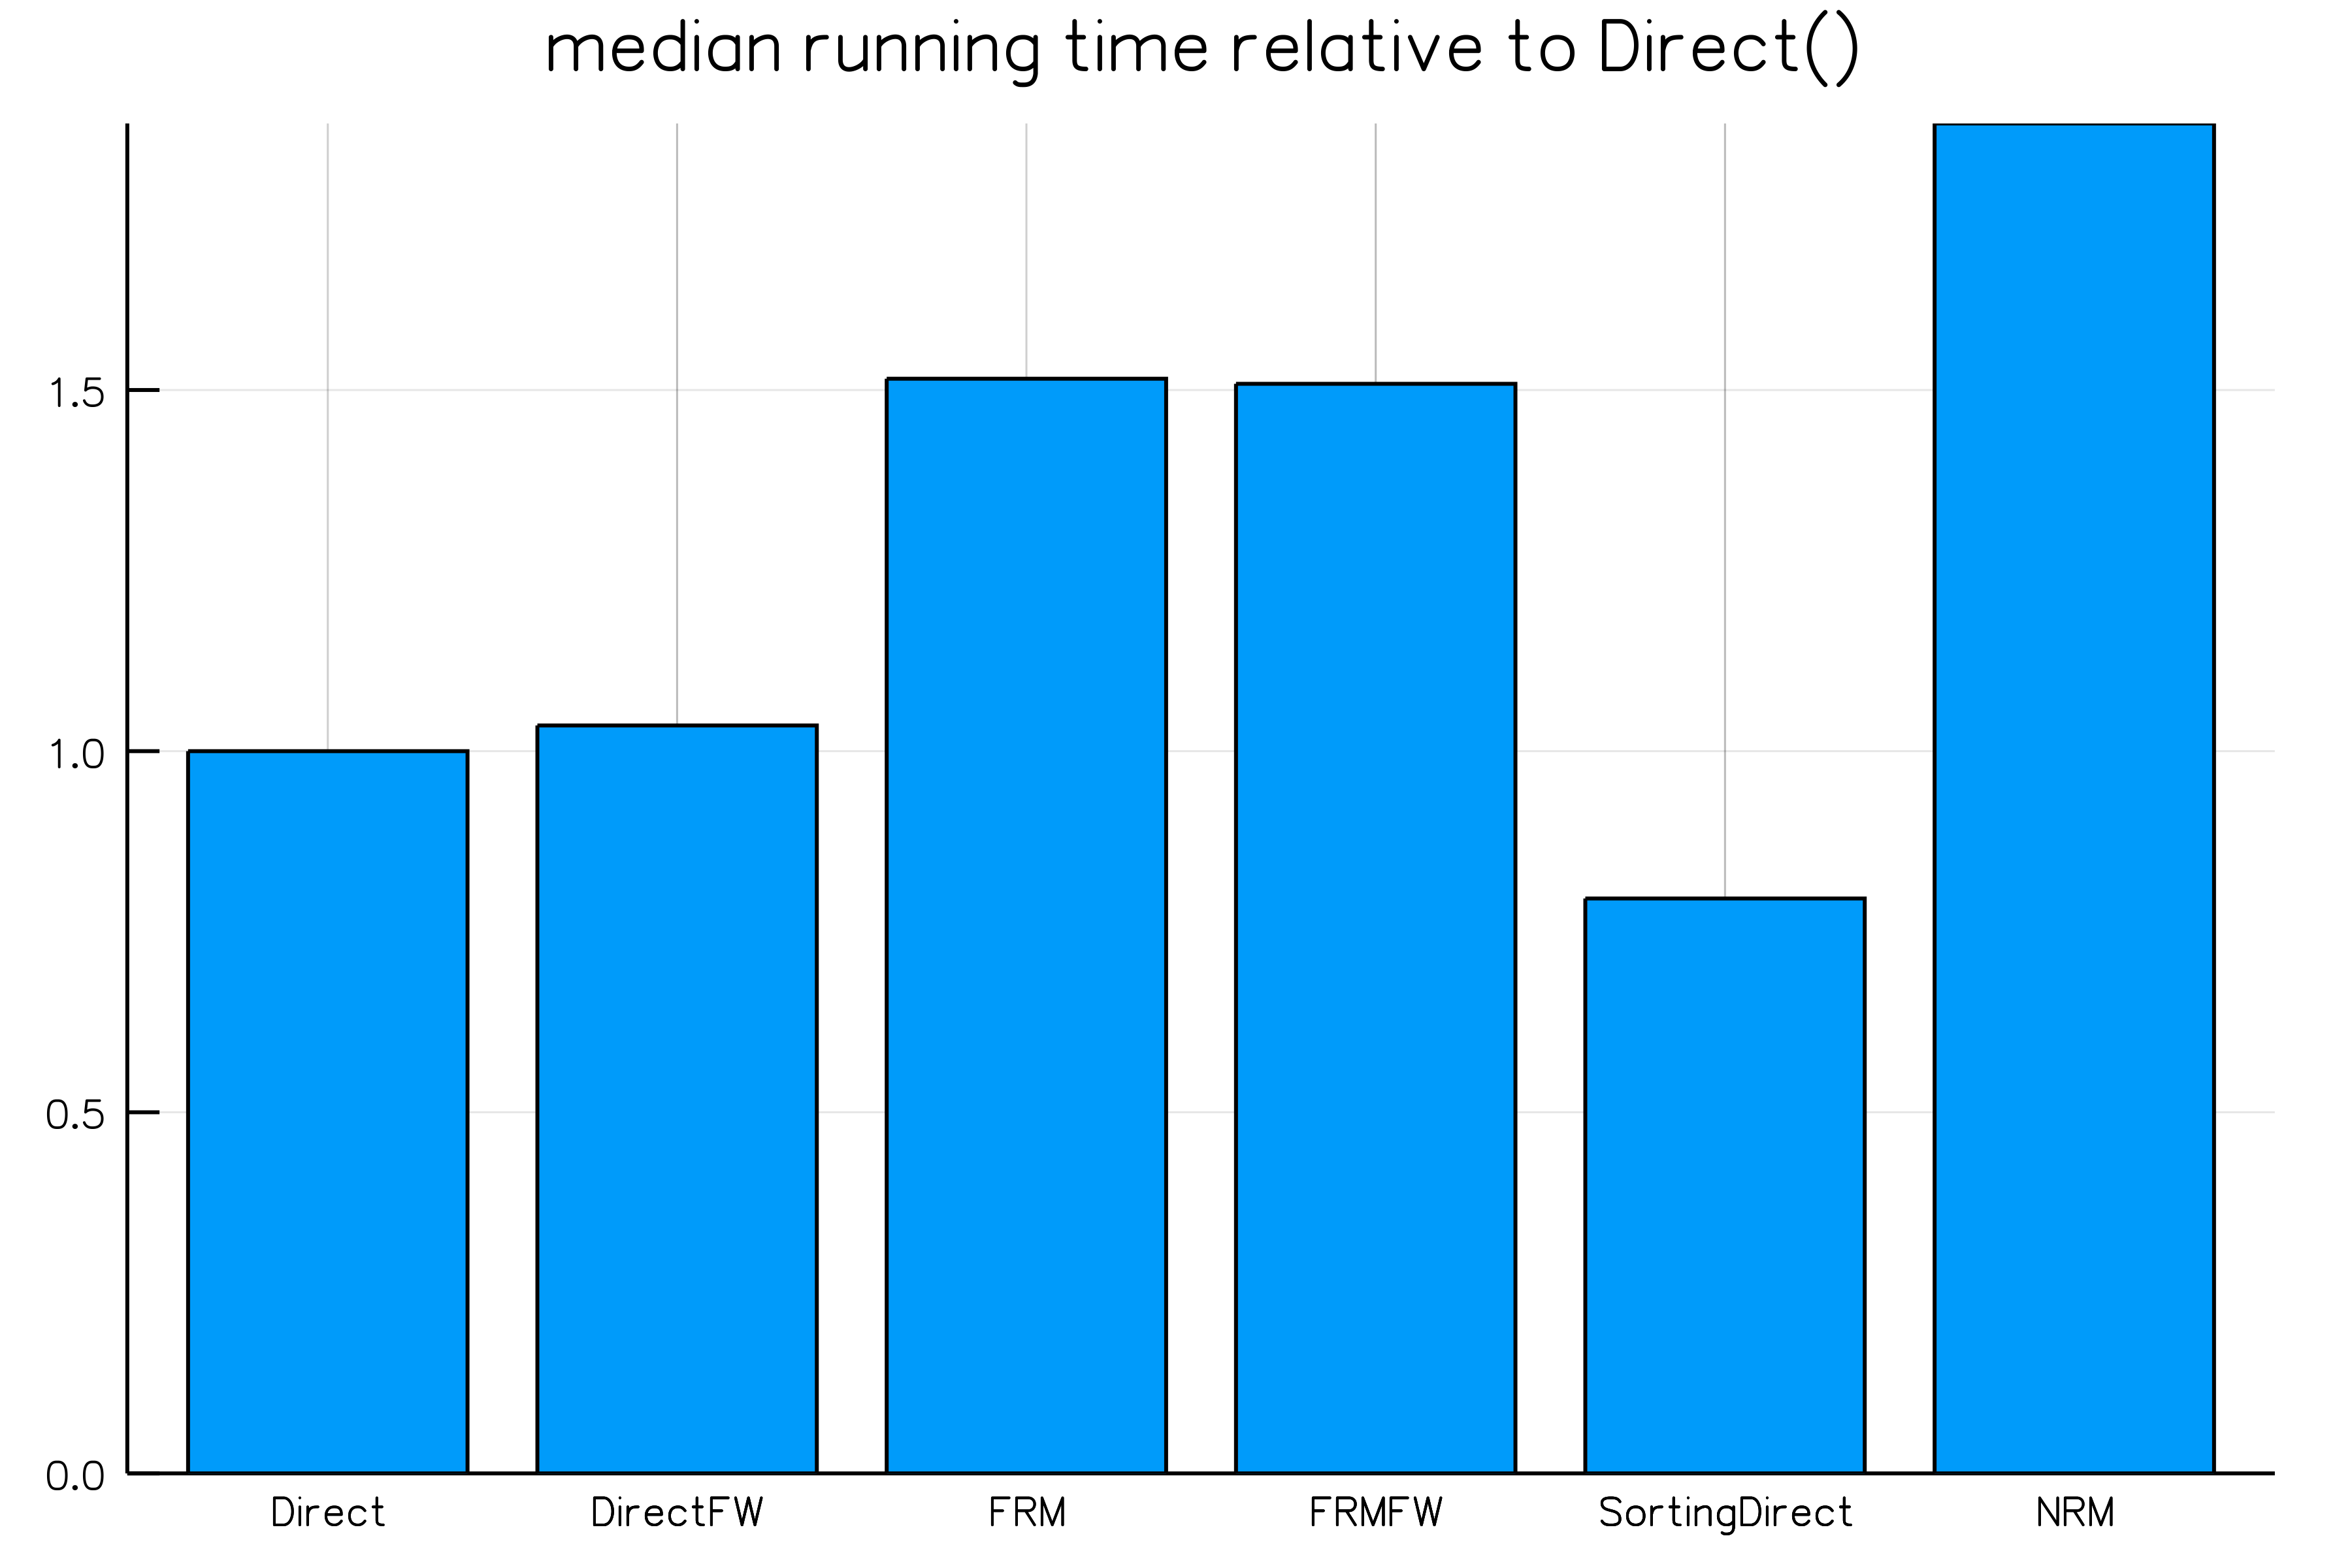

In [10]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)

In [11]:
using DataFrames
# convert times to units of ms
df = DataFrame(names=shortlabels,medtimes=(medtimes/1e6),relmedtimes=relmed)

,names,medtimes,relmedtimes
1,Direct,185.165,1.0
2,DirectFW,191.752,1.03558
3,FRM,280.647,1.51566
4,FRMFW,279.334,1.50857
5,SortingDirect,147.387,0.795979
6,NRM,346.08,1.86904
